# GANs and Latent space interpolation and Vector Addition

### Imports

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])])



### MNIST dataset loading

Loading the MNIST dataset 

Visualizing images

(Images have been transformed to the right size, converted to Tensor and Normalized as well)

In [33]:
#make sue of the Dataloaeer to load the data
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
batch_size = 64  # You can adjust the batch size as needed
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

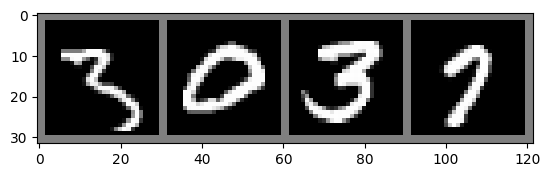

3 0 3 7


In [34]:
import torchvision.utils as utils

# Visualize the MNIST Dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(utils.make_grid(images[:4]))

# Print labels
print(' '.join(f'{labels[j]}' for j in range(4)))
 

### Setting up the GENERATOR and DISCRIMINATOR

In [35]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        
        self.init_size = 7  # Initial size before upscaling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [36]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Flatten(),
            nn.Linear(512*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        validity = self.model(img)
        return validity


In [37]:
latent_dim = 100  
img_shape = 28*28  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)


Using device: cuda:0


### Loss and Optimizers 
#### Binary Cross Entropy Loss and Adam Optimizer for both the Generator and Discriminator

In [39]:
# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

### Training loop

Load the data

Preprocess and some Image Augmentation

Train the model

Some brief training loop steps

Each epoch involves a couple of steps:
1. Prep some data both fake and real
2. Train the discriminator with some real data
3. Train the discriminator with some fake data
3. Train the generator

In [40]:
num_epochs=10

# Training Loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator with real images
        discriminator.zero_grad()
        real_images = real_images.to(device)
        
        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)
        d_loss_real.backward()

        # Generate fake images
        z = torch.randn(batch_size, latent_dim, device=device) 
        fake_images = generator(z)

        # Train Discriminator with fake images
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss_fake.backward()
        optimizer_d.step()

        # Train Generator
        generator.zero_grad()
        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_g.step()

        if i % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
                f"Discriminator Loss: {(d_loss_real + d_loss_fake).item():.4f}, "
                f"Generator Loss: {g_loss.item():.4f}"
            )


# Save the trained models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


Epoch [0/10], Step [0/938], Discriminator Loss: 1.3939, Generator Loss: 0.6832
Epoch [0/10], Step [100/938], Discriminator Loss: 0.2577, Generator Loss: 3.2331
Epoch [0/10], Step [200/938], Discriminator Loss: 1.2768, Generator Loss: 1.3706
Epoch [0/10], Step [300/938], Discriminator Loss: 0.8233, Generator Loss: 1.5990
Epoch [0/10], Step [400/938], Discriminator Loss: 0.4974, Generator Loss: 2.1559
Epoch [0/10], Step [500/938], Discriminator Loss: 1.1512, Generator Loss: 1.2181
Epoch [0/10], Step [600/938], Discriminator Loss: 0.5817, Generator Loss: 2.5433
Epoch [0/10], Step [700/938], Discriminator Loss: 0.4101, Generator Loss: 2.5314
Epoch [0/10], Step [800/938], Discriminator Loss: 0.3316, Generator Loss: 3.4182
Epoch [0/10], Step [900/938], Discriminator Loss: 0.6581, Generator Loss: 2.3236
Epoch [1/10], Step [0/938], Discriminator Loss: 0.3981, Generator Loss: 1.6871
Epoch [1/10], Step [100/938], Discriminator Loss: 1.7236, Generator Loss: 1.2053
Epoch [1/10], Step [200/938], Di

### Display images using the Generator Model

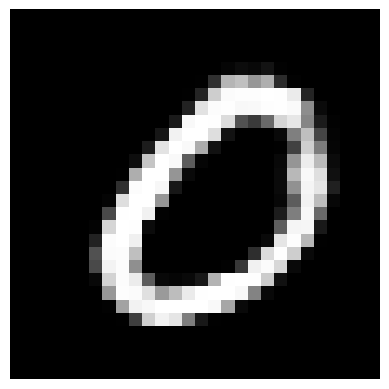

In [41]:
# Define the generator model with the specified latent dimension size.
generator = Generator(latent_dim)  

# Load the pre-trained weights into the generator model from the specified file.
generator.load_state_dict(torch.load('generator.pth'))

# Move the generator model to the designated computing device (e.g., CPU or GPU).
generator.to(device) 

# Set the generator model to evaluation mode. This is important because some models may use mechanisms like dropout or batch normalization that behave differently during training and inference.
generator.eval() 

# Generate a random noise vector z with a normal distribution. The size of z is (1, latent_dim), where 1 is the batch size and latent_dim is the dimensionality of the latent space.
z = torch.randn(1, latent_dim, device=device) 

# Disable gradient calculations to save memory and computations since we are only doing inference here.
with torch.no_grad():
    # Generate an image from the noise vector z using the generator model. The output is reshaped to 28x28, which is the expected image size.
    generated_image = generator(z).view(28, 28).cpu().numpy() 

# Use matplotlib to display the generated image. The colormap 'gray' is used to display the image in grayscale.
plt.imshow(generated_image, cmap='gray')

# Turn off the axis to have a clean image without any axis ticks or labels.
plt.axis('off')

# Display the image.
plt.show()

# Setting up latent space interpolation  


Alright then, now that we are done with generating images, next lets take a look at the models latent space. 

What is it, and how do we use it?

The latent space is the space of all possible inputs that the generator can take, and it is a vector space, and since it is a vector space we can do some vector operations on it, such as interpolation, which is what we will be doing here.

To read up more on this, you can visit the following link: https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/ this is a pretty good article on the topic, which also talks about an implementation of this, we will be doing something similar here.

So what you have to do here is generate two images of random numbers, once you have done this you have to interpolate between them, and display the images at each step of the interpolation.

# Latent space time (5 marks)


Now that we have the images, lets interpolate between them, So what you have to do here is generate two images of random numbers, once you have done this you have to interpolate between them, and display the images at each step of the interpolation, the result here should be a series of images that show how the generator is transitioning from one image to another, how it goes from an image of 3 it generated to an image of 7 for example.

Please make sure that there are atleast 10 steps including, the final and starting images.

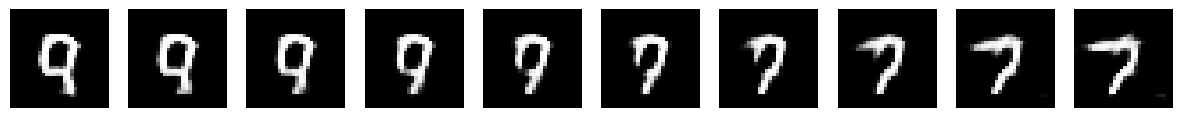

In [91]:
def interpolate_points(p1, p2, n_steps=10):

    ratios = torch.linspace(0, 1, steps=n_steps).unsqueeze(1).to(device) 

    vectors = (1.0 - ratios) * p1 + ratios * p2
    return vectors

point1 = torch.randn(1, latent_dim, device=device)
point2 = torch.randn(1, latent_dim, device=device)

interpolated_points = interpolate_points(point1, point2)

with torch.no_grad():
    interpolated_images = generator(interpolated_points).view(-1, 28, 28).cpu().numpy()

fig, axs = plt.subplots(1, interpolated_images.shape[0], figsize=(15, 15))
for i, img in enumerate(interpolated_images):
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
plt.show()


# Vector arithmatic in the latent space (5 marks)

Ok, so if you were able to do that last part, one thing you may have noticed is that, in certain cases  when transitioning between one number and another, the image takes the form of some completely different number, for example, when transitioning from a 3 to a 6, the image may look like a 5 at some point, before going to a 6.

When we interpolate in this latent space, we're essentially taking a path from the representation of one digit to another. However, because this space is learned from the data and is designed to capture the underlying variations within it, the path between any two points can pass through regions that represent a mix of features from both endpoints. 

This is equivalent to doing arithmetic in the latent space, and it's a powerful tool for manipulating the representations of the data. For example, if we take the representation of the number 1 and add the representation of the number 0, we can obtain a new representation that captures the shared features of both numbers. something that resembles the circular shape of the 0, but also the vertical line segment of the one so a 9.

That is exactly what you have to do, this is what you have to do:

1. Generate 2 images
2. Perform additon on the latent space vectors of the images 
3. Display the results.

do this with atleast 3 different pairs of images.

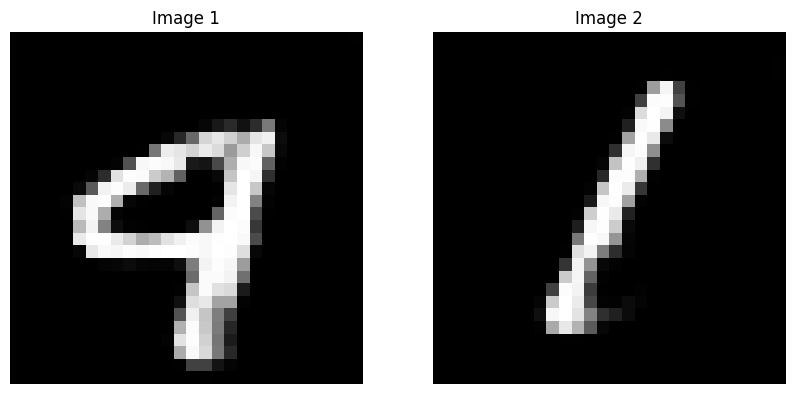

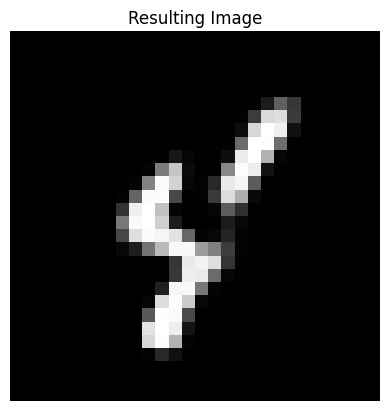

In [94]:
latent_dim = 100

z1 = torch.randn(1, latent_dim, device=device)
z2 = torch.randn(1, latent_dim, device=device)

with torch.no_grad():
    img1 = generator(z1).view(28, 28).cpu().numpy() 
    img2 = generator(z2).view(28, 28).cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('Image 1')
ax[0].axis('off')
ax[1].imshow(img2, cmap='gray')
ax[1].set_title('Image 2')
ax[1].axis('off')
plt.show()

z_new = (z1 + z2) / 2

with torch.no_grad():
    new_img = generator(z_new).view(28, 28).cpu().numpy() 

plt.imshow(new_img, cmap='gray')
plt.title('Resulting Image')
plt.axis('off')
plt.show()


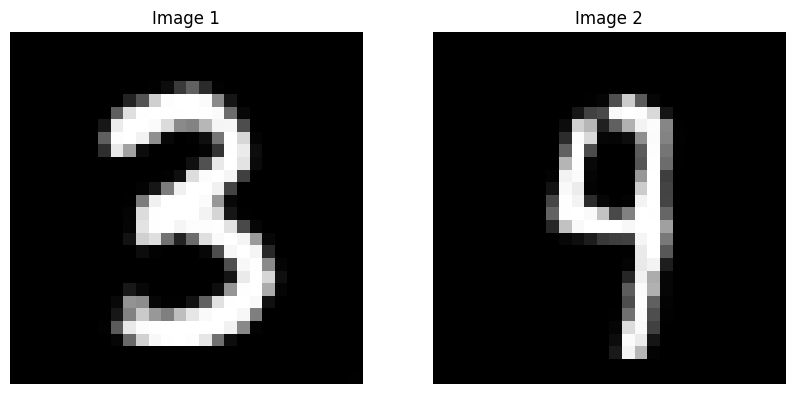

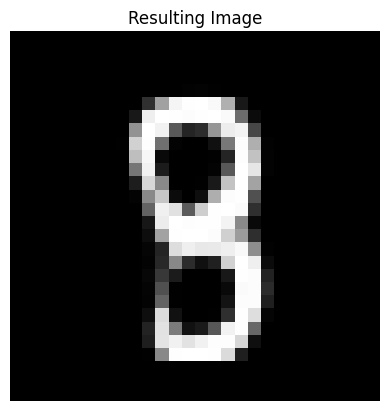

In [111]:


latent_dim = 100

z1 = torch.randn(1, latent_dim, device=device)
z2 = torch.randn(1, latent_dim, device=device)

with torch.no_grad():
    img1 = generator(z1).view(28, 28).cpu().numpy() 
    img2 = generator(z2).view(28, 28).cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('Image 1')
ax[0].axis('off')
ax[1].imshow(img2, cmap='gray')
ax[1].set_title('Image 2')
ax[1].axis('off')
plt.show()

z_new = (z1 + z2) / 2

with torch.no_grad():
    new_img = generator(z_new).view(28, 28).cpu().numpy() 

plt.imshow(new_img, cmap='gray')
plt.title('Resulting Image')
plt.axis('off')
plt.show()


# Some Analytical questions (5)

Q1) What would happen if you were to reduce the size of the dataset to 1/2 the number of images, and then train the GAN, how would the results differ, and why? Please do the following:

1. Train the GAN with the 1/2 the dataset
2. Generate images using this newly trained model
3. Along with a couple of images give reasoning for the results, as well as a description of the results.

Using device: cuda:0
Epoch [1/10], Step [1/469], D Loss: 1.3925, G Loss: 0.6836
Epoch [1/10], Step [101/469], D Loss: 0.2016, G Loss: 3.9608
Epoch [1/10], Step [201/469], D Loss: 0.8843, G Loss: 1.1367
Epoch [1/10], Step [301/469], D Loss: 1.3148, G Loss: 1.5066
Epoch [1/10], Step [401/469], D Loss: 1.3211, G Loss: 1.2807
Epoch [2/10], Step [1/469], D Loss: 1.4416, G Loss: 0.9808
Epoch [2/10], Step [101/469], D Loss: 0.4714, G Loss: 1.7520
Epoch [2/10], Step [201/469], D Loss: 0.4332, G Loss: 3.0764
Epoch [2/10], Step [301/469], D Loss: 1.6890, G Loss: 0.7819
Epoch [2/10], Step [401/469], D Loss: 0.6056, G Loss: 3.2894
Epoch [3/10], Step [1/469], D Loss: 0.5193, G Loss: 3.2223
Epoch [3/10], Step [101/469], D Loss: 0.3177, G Loss: 3.3591
Epoch [3/10], Step [201/469], D Loss: 0.4765, G Loss: 2.9985
Epoch [3/10], Step [301/469], D Loss: 0.8800, G Loss: 2.1843
Epoch [3/10], Step [401/469], D Loss: 0.5214, G Loss: 2.0666
Epoch [4/10], Step [1/469], D Loss: 0.2324, G Loss: 3.8073
Epoch [4/10

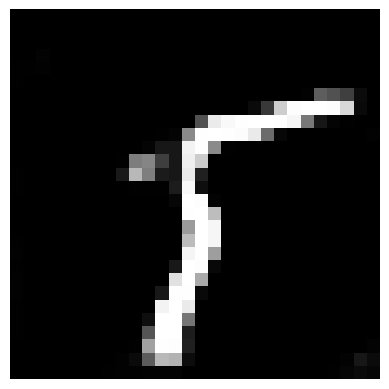

In [95]:
from torch.utils.data import DataLoader, Subset


full_mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)


subset_indices = torch.randperm(len(full_mnist_train))[:len(full_mnist_train) // 2]
mnist_train_half = Subset(full_mnist_train, subset_indices)


batch_size = 64 
train_loader_half = DataLoader(mnist_train_half, batch_size=batch_size, shuffle=True)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)


criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

num_epochs = 10 
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader_half):
       
        discriminator.zero_grad()

        
        real_images = real_images.to(device)

        
        real_labels = torch.ones(real_images.size(0), 1, device=device)
        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)
        d_loss_real.backward()

       
        noise = torch.randn(real_images.size(0), latent_dim, device=device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(fake_images.size(0), 1, device=device)

        
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss_fake.backward()

        optimizer_d.step()

        
        generator.zero_grad()

        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()

        optimizer_g.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader_half)}], "
                  f"D Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G Loss: {g_loss.item():.4f}")


torch.save(generator.state_dict(), 'generator_half.pth')
torch.save(discriminator.state_dict(), 'discriminator_half.pth')


generator.load_state_dict(torch.load('generator_half.pth'))
generator.to(device)
generator.eval()



z = torch.randn(1, latent_dim, device=device)


with torch.no_grad():
    generated_image_half = generator(z).view(28, 28).cpu()  


plt.imshow(generated_image_half.numpy(), cmap='gray')
plt.axis('off')
plt.show()


Ans here:
Limited Diversity: With only half the dataset, the diversity of training examples is reduced. This might lead to a generator that is less capable of producing a wide variety of images. The generated digits might be less varied, or the GAN might learn to replicate a smaller subset of the MNIST digits well, but struggle with less common variations.

Overfitting Risk: The discriminator might become too good at distinguishing real from fake images due to the limited variety, leading to overfitting. This can result in the generator finding it harder to improve, as the discriminator's feedback becomes less meaningful.

Training Stability: With fewer data, the discriminator might learn too quickly compared to the generator, leading to potential training instability. This imbalance might need to be addressed through changes in the training regime, such as altering the learning rates, the ratio of discriminator to generator updates, or employing techniques like label smoothing.

Quality of Generated Images: The quality of the generated images might degrade due to the reasons mentioned above. The images might display less variety, contain more artifacts, or even fail to capture the complexity of some digits.

Q2) What would happen if you were to change the loss function of the GAN, how would the results differ, and why? Please do the following:

1. Train the GAN with a different loss function, this could be any other loss function, it could be any of your choosing.
2. Generate images using this newly trained model.
3. Along with a couple of images give reasoning for the results, as well as a description of the results.

In [102]:
criterion = nn.MSELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Training
n_epochs = 10  # Number of epochs to train

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_loader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Configure input
        real_imgs = imgs.to(device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), 100, device=device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                  f"D Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G Loss: {g_loss.item():.4f}")
        
        


Epoch [1/10], Step [1/938], D Loss: 0.3134, G Loss: 0.9978
Epoch [1/10], Step [101/938], D Loss: 0.3134, G Loss: 0.5919
Epoch [1/10], Step [201/938], D Loss: 0.3134, G Loss: 0.9522
Epoch [1/10], Step [301/938], D Loss: 0.3134, G Loss: 0.8864
Epoch [1/10], Step [401/938], D Loss: 0.3134, G Loss: 0.9965
Epoch [1/10], Step [501/938], D Loss: 0.3134, G Loss: 0.9984
Epoch [1/10], Step [601/938], D Loss: 0.3134, G Loss: 0.9797
Epoch [1/10], Step [701/938], D Loss: 0.3134, G Loss: 0.9291
Epoch [1/10], Step [801/938], D Loss: 0.3134, G Loss: 0.9369
Epoch [1/10], Step [901/938], D Loss: 0.3134, G Loss: 0.9812
Epoch [2/10], Step [1/938], D Loss: 0.3134, G Loss: 0.8778
Epoch [2/10], Step [101/938], D Loss: 0.3134, G Loss: 0.9104
Epoch [2/10], Step [201/938], D Loss: 0.3134, G Loss: 0.9998
Epoch [2/10], Step [301/938], D Loss: 0.3134, G Loss: 0.8813
Epoch [2/10], Step [401/938], D Loss: 0.3134, G Loss: 0.9731
Epoch [2/10], Step [501/938], D Loss: 0.3134, G Loss: 0.9979
Epoch [2/10], Step [601/938]

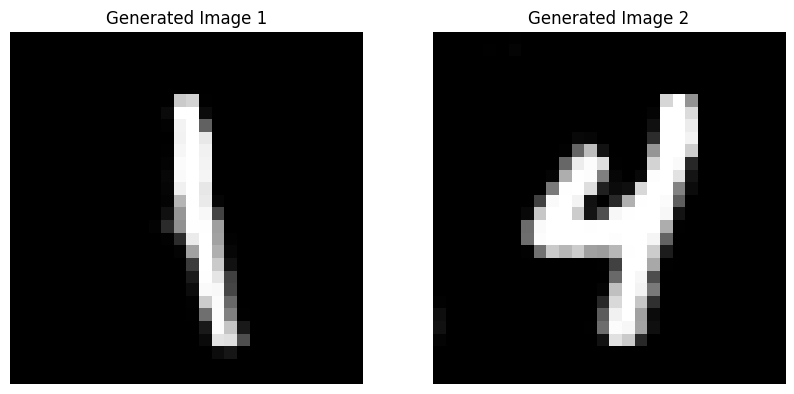

In [112]:
# Generate images with the trained model
with torch.no_grad():
    z = torch.randn(2, 100, device=device)  # Generate two noise samples
    generated_imgs = generator(z).cpu().numpy().squeeze()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, img in enumerate(generated_imgs):
    axes[i].imshow(img.reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Generated Image {i+1}')
    axes[i].axis('off')
plt.show()

Ans here:
Different Convergence Properties: Different loss functions can have different convergence properties, affecting how quickly and stably the GAN trains. For instance, Wasserstein loss with gradient penalty (WGAN-GP) tends to offer more stable training compared to the traditional binary cross-entropy loss.

Mode Collapse: Some loss functions might be more prone to mode collapse, where the generator learns to produce a limited range of outputs. This is often a concern with GANs, and the choice of loss function can exacerbate or mitigate this issue.

Quality and Diversity of Images: The choice of loss function can influence the balance between the fidelity and diversity of the generated images. For example, a loss function that penalizes the generator more harshly for producing obviously fake images might lead to high-quality but less diverse outputs.